In [8]:
import matplotlib.pyplot as plt

from pkg_ML_V1 import *


def generate_output_columns(numOfQubits):
    # Create lists for W_ and decay_ with the appropriate number of elements
    W_columns = ['W_{}'.format(i) for i in range(numOfQubits)]
    decay_columns = ['decay_{}'.format(i) for i in range(numOfQubits)]

    # Create a list for J_ with one less element than W_ and decay_
    J_columns = ['J_{}'.format(i) for i in range(numOfQubits - 1)]

    # Combine the lists to form Output_columns
    Output_columns = W_columns + J_columns + decay_columns
    return Output_columns


def printHistory(history):
    print('loss:', history[1]['loss'][len(history[1]['loss']) - 1])
    print('val_loss:', history[1]['val_loss'][len(history[1]['val_loss']) - 1])
    print('percentage_error_0:', history[1]['percentage_error_0'][len(history[1]['percentage_error_0']) - 1])
    print('val_percentage_error_0:',
          history[1]['val_percentage_error_0'][len(history[1]['val_percentage_error_0']) - 1])


def create_relu_model(neurons_, learning_rate_, concatenated_inputs_):
    hidden_layer_1 = tf.keras.layers.Dense(neurons_, activation='relu')(concatenated_inputs_)
    hidden_layer_2 = tf.keras.layers.Dense(neurons_, activation='relu')(hidden_layer_1)
    hidden_layer_3 = tf.keras.layers.Dense(neurons_, activation='relu')(hidden_layer_2)
    hidden_layer_4 = tf.keras.layers.Dense(neurons_, activation='relu')(hidden_layer_3)
    output = tf.keras.layers.Dense(len(Output_columns))(hidden_layer_4)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_)
    # Metrics for monitoring the learning process
    # Initialize an empty list to hold the metrics for the output
    metrics = ['mean_squared_error', 'mean_absolute_percentage_error']
    for i in range(len(Output_columns)):
        metrics.append(percentage_error(i))

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metrics)

    # print("Learning rate: " + str(learning_rate_))
    # print("Amount of neurons: " + str(neurons_))

    return model



In [39]:
learning_rate = 10 ** -4
epochs = 40
batch_size = 2 ** 8
neurons = 2 ** 8

Output_data = {}
x_arr = []
y_arr = []
y_arr_val=[]

# Specify the directory where the CSV files are located
folder_path = 'Generated_Data'
# List all files in the directory
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        # Attempt to match the filename pattern
        match = re.match(r"Qubits_(\d+)_Lines_(\d+)_TS_(\d+)_Shots_(\d+)_MeanDecay_(\d+)", filename)
        if match:
            # Extract parameters from the filename
            qubits, lines, TS, shots, meanDecay = match.groups()

            # Convert strings to integers
            qubits = int(qubits)
            lines = int(lines)
            TS = int(TS)
            shots = int(shots)
            meanDecay = int(meanDecay)

            # Load the CSV file into a DataFrame
            file_path = os.path.join(folder_path, filename)
            train_df = pd.read_csv(file_path)
            Output_columns = generate_output_columns(qubits)  # Generate the columns to drop
            feature_columns = train_df.columns.drop(Output_columns)
            inputs = {column: tf.keras.layers.Input(shape=(1,), name=column) for column in feature_columns}
            concatenated_inputs = tf.keras.layers.concatenate(inputs.values())
            # Prepare training data
            train_features = {column: train_df[column] for column in inputs}
            train_labels = train_df[Output_columns]
            # Create Model:
            print("Working on:", filename)
            model = create_relu_model(neurons, learning_rate, concatenated_inputs)

            history = train_model(model, train_features, train_labels,
                                  epochs, batch_size, validation_split=0.1)
            Output_data[filename] = history
            printHistory(history)
            #Save data for Plots:
            x_arr.append(meanDecay)
            temp = history[1]
            # y_arr.append(temp['percentage_error_0'][len(temp['percentage_error_0']) - 1])
            # y_arr_val.append(temp['val_percentage_error_0'][len(temp['val_percentage_error_0']) - 1])
            y_arr.append(temp['mean_squared_error'][len(temp['mean_squared_error']) - 1])
            y_arr_val.append(temp['val_mean_squared_error'][len(temp['mean_squared_error']) - 1])


Working on: Qubits_2_Lines_10000_TS_10_Shots_1000_MeanDecay_1.csv


KeyboardInterrupt: 

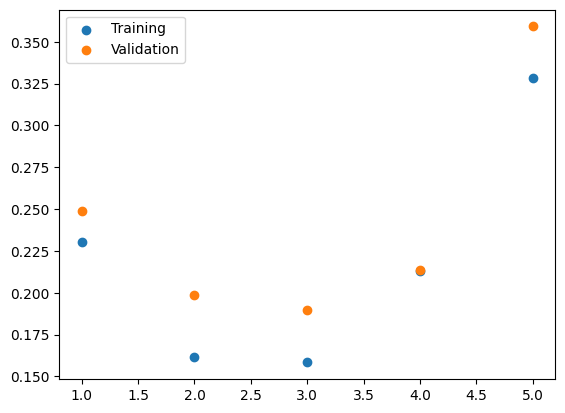

In [37]:
plt.scatter(x_arr,y_arr,label='Training')
plt.scatter(x_arr,y_arr_val,label='Validation')
plt.legend()
plt.show()

Modeling a Single File:
=====

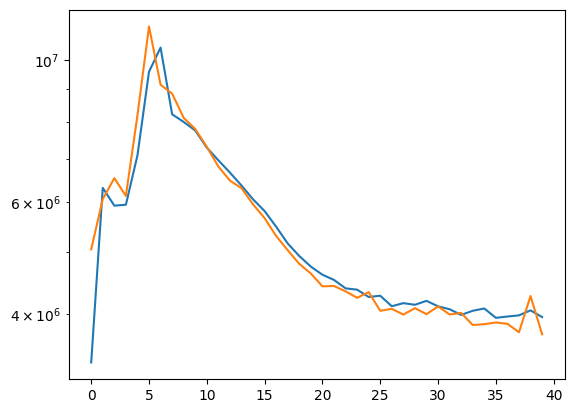

In [33]:
Data_to_show = Output_data['Qubits_2_Lines_10000_TS_10_Shots_1000_MeanDecay_3.csv'][1]
plt.plot(Data_to_show['mean_absolute_percentage_error'])
plt.plot(Data_to_show['val_mean_absolute_percentage_error'])
plt.yscale('log')


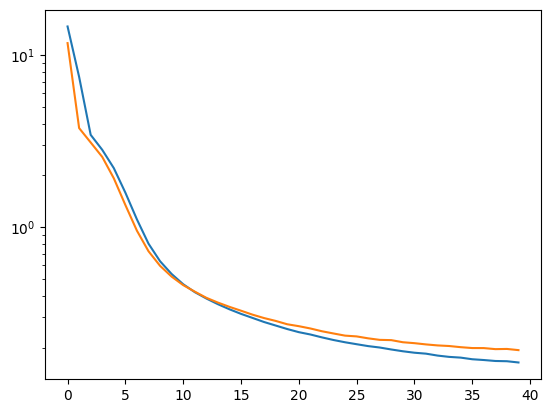

In [31]:
Data_to_show = Output_data['Qubits_2_Lines_10000_TS_10_Shots_1000_MeanDecay_3.csv'][1]
mse = ['mean_squared_error']
val_mse = ['val_mean_squared_error']
plt.plot(mse)
plt.plot(val_mse)
plt.yscale('log')
